### Maze Example

In [29]:
import numpy as np
import pandas as pd
import tabulate
import matplotlib.pyplot as plt

In [10]:
maze = np.zeros((6,6))
maze[0,0] = 2
maze[5,:5] = 1
maze[:4, 5] = 1
maze[2, 2:] = 1
maze[3, 2] = 1
maze

array([[2., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0.]])

In [ ]:
R 0 0 0 0 X
0 0 0 0 0 X
0 0 X X X X
0 0 X 0 0 X
0 0 0 0 0 0 
X X X X X 0 <- END

In [26]:
ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

class Maze(object):

    def __init__(self):
        # 6 Lists with 6 entries
        self.maze = np.zeros((6,6))
        self.maze[0,0] = 2
        self.maze[5,:5] = 1
        self.maze[:4, 5] = 1
        self.maze[2, 2:] = 1
        self.maze[3, 2] = 1
        self.robot_position = (0, 0) # current robot position
        self.steps = 0 # contains num steps robot took
        self.allowed_states = None # for now, this is none
        self.construct_allowed_states() # not implemented yet
    
    def print_maze(self):
        print('---------------------------------')
        for row in self.maze:
            for col in row:
                if col == 0:
                    print('', end="\t") # empty space
                elif col == 1:
                    print('X', end="\t") # walls
                elif col == 2:
                    print('R', end="\t") # robot position
            print("\n")
        print('---------------------------------')
    
    def is_allowed_move(self, state, action):
        y, x = state
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        # moving off the board
        if y < 0 or x < 0 or y > 5 or x > 5:
            return False
        # moving into start position or empty space
        if self.maze[y, x] == 0 or self.maze[y, x] == 2:
            return True
        else:
            return False
    
    def construct_allowed_states(self):
        allowed_states = {}
        # index and then the whole row
        for y, row in enumerate(self.maze):
            # index and then the columns
            for x, col in enumerate(row):
                # iterate through all valid spaces
                if self.maze[(y,x)] != 1:
                    allowed_states[(y,x)] = []
                    for action in ACTIONS:
                        if self.is_allowed_move((y, x), action):
                            # all the nearby positions which are allowed have a "TRUE" entry
                            allowed_states[(y,x)].append(action)
        self.allowed_states = allowed_states
    
    def update_maze(self, action):
        y, x = self.robot_position
        self.maze[y, x] = 0 # set the current position to empty
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        self.robot_position = (y, x)
        self.maze[y, x] = 2
        self.steps += 1

    def get_state_and_reward(self):
        return self.robot_position, self.give_reward()

    def give_reward(self):
        # if at end give 0 reward
        # if not at end give -1 reward
        if self.robot_position == (5, 5):
            return 0
        else: 
            return -1
    
    def isGameOver(self):
        if self.robot_position == (5, 5):
            return True
        return False
            

### Reward explanation
The agent will try to estimate the loss of each of its action choices, then take an action, then get the real reward of the action from the environment, then adjust its future predictions for that particular action.

We penalize -1 for every step the robot takes (as we want the fastest solution, not just any solution) and then reward 0 points when the robot reaches the end. Thus, a solution that takes 20 steps will reward the agent a total of -20 points and a solution that takes 10 steps will reward the agent -10 points.



In [22]:
# Example Expected Reward
data = {
    "State": ["(0, 0)", "(1, 0)", "...", "(X, Y)"],
    "Expected Reward": [-9, -8, "...", "G"]
}
df = pd.DataFrame(data)
df

,State,Expected Reward
0,"(0, 0)",-9
1,"(1, 0)",-8
2,...,...
3,"(X, Y)",G


G is the given expected reward for a state (X, Y). But our robot will start with a randomized state table, as it doesn’t actually know the expected rewards for any given state yet, and will try to converge to G for each state.

Our learning formula is $G_{state} = G_{state} + \alpha(target - G_{state})$. 

We’re essentially adding some percentage of the difference between the actual rewards (target) and our original expected rewards for that given state. You can think of this difference as the loss.




In practice, at the end of one episode, the robot has memorized all its states and resulting rewards. It also knows its current G table. Using this formula, the robot will update each row in the G table according to this simple formula.

- $\alpha$: is the learning rate: How much the new information (difference between target and current value) should influence the update.
- $target$: This is the acutal reward. The value the agent is trying to achieve for the state. It can be calculated based on the rewards received and the estimated value of the next state (in algorithms like Q-learning, the target is usually the reward plus the discounted value of the next state).

- **Convergence:** The formula is designed to iteratively adjust the estimated value of the state $G_{state}$ toward the target. Over time, as the agent experiences more states and updates its values, these estimates ($G_{state}$) will converge towards the true expected rewards.

- **Memory of States:** The robot or agent, after experiencing an episode (a series of actions and resulting states), will have a memory of the rewards and transitions it has encountered. It will then use this memory to update the table of expected rewards.

- **Learning in Episodes:** Typically, the learning happens at the end of an episode or after each action, depending on the algorithm. After each update, the new estimate of $G_{state}$ is used in future decisions, gradually improving the agent's performance.

- **Intuition:** Imagine you are trying to predict the score of a sports team. Initially, you have no idea, so you might guess randomly. After watching a few games, you notice the team's average performance and start adjusting your predictions. Each time you watch a game (receive new information), you update your prediction (G_state) a little bit in the direction of what you observed (target). Over time, your predictions get better and closer to the actual performance.


In [27]:
ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

class Agent(object):
    
    def __init__(self, states, alpha=0.15, random_factor=0.2):
        
        self.state_history = [((0, 0), 0)] # state, reward
        self.alpha = alpha
        self.random_factor = random_factor
        # start the rewards table (expected reward)
        self.G = {}
        self.init_reward(states)
    
    # Initial state reward table
    def init_reward(self, states):
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(j,i)] = np.random.uniform(high=1.0, low=0.1)
    
    def choose_action(self, state, allowed_moves):
        next_move = None
        n = np.random.random()
        if n < self.random_factor:
            next_move = np.random.choice(allowed_moves)
        else:
            maxG = -10e15 # some really small random number
            for action in allowed_moves:
                # e.g.
                # state = (2, 3)
                # ACTIONS[action] = (1, -1)
                # New state = (3,2)
                new_state = tuple([sum(x) for x in zip(state, ACTIONS[action])])
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

    # The loop iterates through this history in reverse order, meaning it starts from the most recent state and works backward to the first state in the history.
    # This reverse order is important because it allows the agent to update its value estimates in the reverse temporal order.
    def learn(self):
        target = 0 # we know the "ideal" reward
        a = self.alpha
        for state, reward in reversed(self.state_history):
            self.G[state] = self.G[state] + a * (target - self.G[state])
        self.state_history = [] # reset the state_history
        self.random_factor -= 10e-5 # decrease random_factor

    def give_reward(self):
        if self.robot_position == (5, 5):
            return 0
        else:
            return -1
        
    def get_state_and_reward(self):
        return self.robot_position, self.give_reward()


0
1000
2000
3000
4000


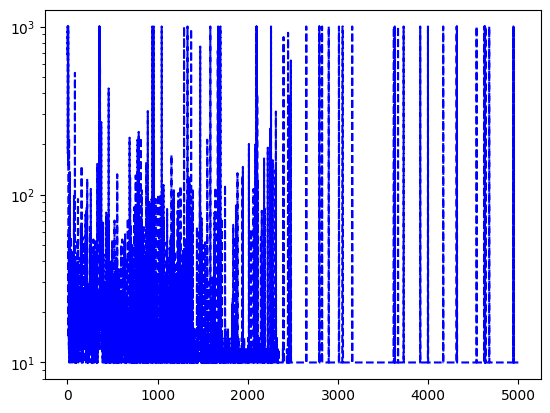

In [31]:

maze = Maze()
robot = Agent(maze.maze, alpha=0.1, random_factor=0.25)
moveHistory = []

for i in range(5000):
    if i % 1000 == 0:
        print(i)

    while not maze.isGameOver():
        state, _ = maze.get_state_and_reward() # get the current state
        action = robot.choose_action(state, maze.allowed_states[state]) # choose an action (explore or exploit)
        maze.update_maze(action) # update the maze according to the action
        state, reward = maze.get_state_and_reward() # get the new state and reward
        robot.update_state_history(state, reward) # update the robot memory with state and reward
        if maze.steps > 1000:
            # end the robot if it takes too long to find the goal
            maze.robot_position = (5, 5)
    
    robot.learn() # robot should learn after every episode
    moveHistory.append(maze.steps) # get a history of number of steps taken to plot later
    maze = Maze() # reinitialize the maze

plt.semilogy(moveHistory, "b--")
plt.show()